In [1]:
import torch
import torch.nn as nn
import torch_geometric.nn as gnn
from torch_geometric.data import Data
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Empty graph
graph = nx.Graph()


In [2]:

# Load MNDR dataset (assuming it's in CSV format)
mndrFinal = pd.read_csv('mndrFinal.csv')
schi = pd.read_csv('SchizNPINTERFinal.csv')


In [3]:

# Extract relevant features
rna_symbols = mndrFinal['ncName']
categories = mndrFinal['ncType']
scores = mndrFinal['Score']
rna_features = pd.get_dummies(categories, dtype=int)  # One-hot encode categories
rna_features['Score'] = scores
rna_features.index= mndrFinal['ncName']


In [4]:

# Add nodes for MNDR dataset
for rna in rna_symbols:
    graph.add_node(rna, features=rna_features.loc[rna])


In [5]:
# Add edges from SchizNPINTER dataset
edges = schi[['ncName', 'tarName', 'interID', 'organism', 'level', 'class']]
ef=pd.get_dummies(schi[['organism', 'level', 'class']],dtype=int)
ef.index=schi['interID']
edges.index=schi['interID']
node_index = {nc_name: i for i, nc_name in enumerate(rna_symbols)}
edges['nc_index'] = edges['ncName'].map(node_index)
# edges['nc_index']= edges.loc[:, 'ncName'].map(node_index)
# print(edges['nc_index'])
edges['tar_index'] = edges['tarName'].map(node_index)
# edges['tar_index']= edges.loc[:, 'tarName'].map(node_index)
for _, row in edges.iterrows():
    nc_name = row['nc_index']
    tar_name = row['tar_index'] 
    graph.add_edge(nc_name, tar_name, edge_features=ef.loc[row['interID']])
# edge_index = torch.tensor(list(graph.edges)).t().contiguous()
print('Graph successfully created')

C:\Users\Urveesh\AppData\Local\Temp\ipykernel_21828\3001170010.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges['nc_index'] = edges['ncName'].map(node_index)
C:\Users\Urveesh\AppData\Local\Temp\ipykernel_21828\3001170010.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges['tar_index'] = edges['tarName'].map(node_index)


Graph successfully created


In [6]:
def a(row):
    return int(row)
edges['nc_index']=edges['nc_index'].apply(a)
edges['tar_index']=edges['tar_index'].apply(a)

    

C:\Users\Urveesh\AppData\Local\Temp\ipykernel_21828\1053351203.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges['nc_index']=edges['nc_index'].apply(a)
C:\Users\Urveesh\AppData\Local\Temp\ipykernel_21828\1053351203.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges['tar_index']=edges['tar_index'].apply(a)


In [7]:
node_features = torch.tensor(rna_features.values,dtype=float)
edge_attr = torch.tensor(ef.values)

# Above part is sorted
edge_index = torch.tensor(list(graph.edges),dtype=torch.long).t().contiguous()
  # Assign actual scores
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=scores)
data.x = data.x.float()

## Graph Sage

Epoch 0: Train MSE: 0.6728678345680237, Val MSE: 0.7529628872871399 and R2 is -7.477332985179595
Epoch 1: Train MSE: 0.5547242164611816, Val MSE: 0.6560553312301636 and R2 is -6.38628588778274
Epoch 2: Train MSE: 0.5077499747276306, Val MSE: 0.5918371677398682 and R2 is -5.6632768446838835
Epoch 3: Train MSE: 0.4506244361400604, Val MSE: 0.4912196397781372 and R2 is -4.530461394623987
Epoch 4: Train MSE: 0.3777882158756256, Val MSE: 0.3917614221572876 and R2 is -3.4106977043351003
Epoch 5: Train MSE: 0.35903534293174744, Val MSE: 0.39060795307159424 and R2 is -3.397711918564811
Epoch 6: Train MSE: 0.3196024000644684, Val MSE: 0.3310562074184418 and R2 is -2.7272402149814097
Epoch 7: Train MSE: 0.26576516032218933, Val MSE: 0.33257991075515747 and R2 is -2.744394910878556
Epoch 8: Train MSE: 0.2501961588859558, Val MSE: 0.31508010625839233 and R2 is -2.547371227172517
Epoch 9: Train MSE: 0.19485771656036377, Val MSE: 0.3023504316806793 and R2 is -2.4040527238090337
Epoch 10: Train MSE: 

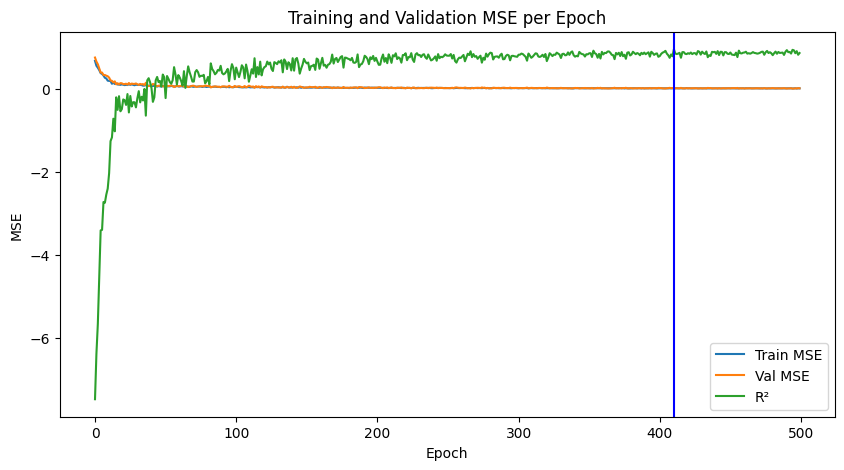

Predicted scores for unknown nodes: tensor([[-0.1682],
        [-0.1382],
        [-0.1354],
        ...,
        [-0.0545],
        [-0.0193],
        [-0.1206]])
Minimum Validation MSE: 0.004130454268306494 at epoch 410
 Training MSE: 0.011107999831438065
Best R² score: 0.953496734417724 at epoch 410


In [14]:
import random

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Set the seed
set_seed(42)

class GraphSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGE, self).__init__()
        self.conv1 = gnn.SAGEConv(input_dim, hidden_dim)
        self.conv2 = gnn.SAGEConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

    def predict(self, x, edge_index):
        with torch.no_grad():
            predicted_scores = self.forward(x, edge_index)
        return predicted_scores

# Assuming your data is in the `data` object
input_dim = node_features.shape[1]  # Number of input features
hidden_dim = 128  # Adjust as needed
output_dim = 1  # Predicting a single score

model_Sage = GraphSAGE(input_dim, hidden_dim, output_dim)

# Optimizer and loss function
optimizer = torch.optim.Adam(model_Sage.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Ensure data.y is a Tensor
if not isinstance(data.y, torch.Tensor):
    data.y = torch.tensor(data.y, dtype=torch.float32)

# Split data into training and validation sets
valid_labels = data.y != -1
train_indices, val_indices = train_test_split(torch.where(valid_labels)[0], test_size=0.2, random_state=42)

train_losses = []
val_losses = []
r2_scores = []

# Training loop
for epoch in range(500):
    model_Sage.train()
    optimizer.zero_grad()
    out = model_Sage(data.x, data.edge_index)
    out = out.view(-1)
    # Select outputs and targets for training
    train_outputs = out[train_indices]
    train_targets = data.y[train_indices]
    # Calculate training loss
    train_loss = criterion(train_outputs, train_targets)
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())
    # Evaluation on validation set
    model_Sage.eval()
    with torch.no_grad():
        val_outputs = out[val_indices]
        val_targets = data.y[val_indices]
        val_loss = criterion(val_outputs, val_targets)
        val_losses.append(val_loss.item())
        r2 = r2_score(val_targets.cpu().numpy(), val_outputs.cpu().numpy())
        r2_scores.append(r2)

    print(f"Epoch {epoch}: Train MSE: {train_loss.item()}, Val MSE: {val_loss.item()} and R2 is {r2}")

# Plot training and validation MSE
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train MSE')
plt.plot(val_losses, label='Val MSE')
plt.plot(r2_scores, label='R²')
plt.axvline(x = r2_scores.index(max(r2_scores)), color = 'b',linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Validation MSE per Epoch')
plt.legend()
plt.show()

# Predict for nodes with unknown labels
model_Sage.eval()
with torch.no_grad():
    predicted_scores = model_Sage(data.x, data.edge_index)
    unknown_labels = data.y == -1
    predicted_unknown_scores = predicted_scores[unknown_labels]
    print("Predicted scores for unknown nodes:", predicted_unknown_scores)

print(f'Minimum Validation MSE: {min(val_losses)} at epoch {val_losses.index(min(val_losses))}')
print(f' Training MSE: {train_losses[val_losses.index(min(val_losses))]}')
print(f'Best R² score: {max(r2_scores)} at epoch {r2_scores.index(max(r2_scores))}')


In [24]:
# Assuming `data.y` is your original tensor of scores
# and `predicted_unknown_scores` is the tensor of predicted scores for nodes with -1

# Convert tensors to numpy arrays
original_scores = data.y.cpu().numpy()
predicted_scores = predicted_unknown_scores.cpu().numpy()

# Find indices where the original scores are -1
unknown_indices = np.where(original_scores == -1)[0]

# Replace -1 values with predicted scores
original_scores[unknown_indices] = predicted_scores.flatten()

# Ensure that any scores less than 0 are set to 0
original_scores = np.maximum(original_scores, 0)

# Assuming you have a DataFrame `df` with the original data
# Create a new column with the updated scores
mndrFinal['updated_scores'] = original_scores

# Display the DataFrame with the new column
# print(mndrFinal.head())
mndrFinal.to_csv('SagePrediction.csv',index=False)


## GCN

Epoch 0: Train MSE: 0.21979336440563202, Val MSE: 0.31767573952674866 and R2 is -2.576594751743597
Epoch 1: Train MSE: 0.20309077203273773, Val MSE: 0.24179625511169434 and R2 is -1.7222950335569363
Epoch 2: Train MSE: 0.2442270964384079, Val MSE: 0.2904011011123657 and R2 is -2.269519326654132
Epoch 3: Train MSE: 0.18361182510852814, Val MSE: 0.2570399045944214 and R2 is -1.893918063627972
Epoch 4: Train MSE: 0.17998263239860535, Val MSE: 0.24201279878616333 and R2 is -1.7247331821862661
Epoch 5: Train MSE: 0.21704788506031036, Val MSE: 0.28861603140830994 and R2 is -2.2494216870415684
Epoch 6: Train MSE: 0.1673584133386612, Val MSE: 0.29080647230148315 and R2 is -2.274083273769862
Epoch 7: Train MSE: 0.16078078746795654, Val MSE: 0.24738770723342896 and R2 is -1.7852472436341662
Epoch 8: Train MSE: 0.155073881149292, Val MSE: 0.244183748960495 and R2 is -1.749175262891534
Epoch 9: Train MSE: 0.14937156438827515, Val MSE: 0.22118744254112244 and R2 is -1.4902683206041307
Epoch 10: Tra

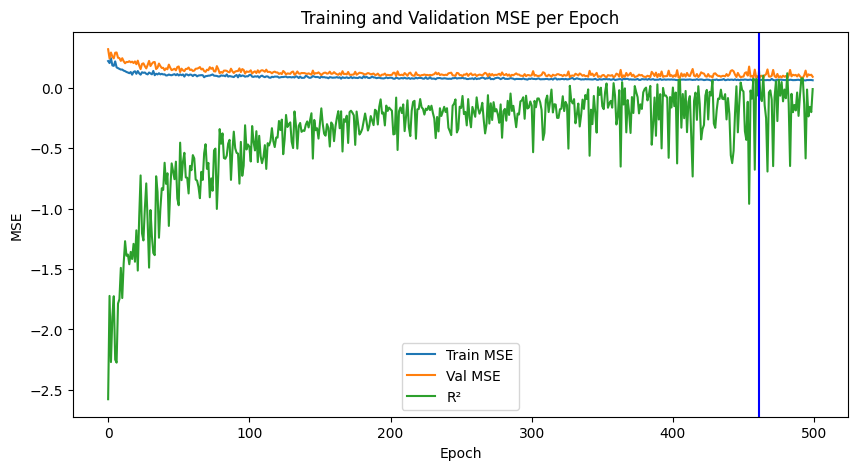

Predicted scores for unknown nodes: tensor([[0.7258],
        [0.4848],
        [0.3826],
        ...,
        [0.2867],
        [0.6264],
        [0.9378]])
Minimum Validation MSE: 0.07648606598377228 at epoch 461
 Training MSE: 0.06296924501657486
Best R² score: 0.1388715537395272 at epoch 461


In [18]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Set the seed
set_seed(42)

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = gnn.GCNConv(input_dim, hidden_dim)
        self.conv2 = gnn.GCNConv(hidden_dim, hidden_dim)
        self.conv3 = gnn.GCNConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return x

    def predict(self, x, edge_index):
        with torch.no_grad():
            predicted_scores = self.forward(x, edge_index)
        return predicted_scores

# Assuming your data is in the `data` object
input_dim = node_features.shape[1]  # Number of input features
hidden_dim = 128  # Adjust as needed
output_dim = 1  # Predicting a single score

model_GCN = GCN(input_dim, hidden_dim, output_dim)

# Optimizer and loss function
optimizer = torch.optim.Adam(model_GCN.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Split data into training and validation sets
valid_labels = data.y != -1
train_indices, val_indices = train_test_split(torch.where(valid_labels)[0], test_size=0.2, random_state=42)

train_losses = []
val_losses = []
r2_scores = []

# Training loop
for epoch in range(500):
    model_GCN.train()
    optimizer.zero_grad()
    out = model_GCN(data.x, data.edge_index)
    out = out.view(-1)
    # Select outputs and targets for training
    train_outputs = out[train_indices]
    train_targets = data.y[train_indices]
    # Calculate training loss
    train_loss = criterion(train_outputs, train_targets)
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())
    # Evaluation on validation set
    model_GCN.eval()
    with torch.no_grad():
        val_outputs = out[val_indices]
        val_targets = data.y[val_indices]
        val_loss = criterion(val_outputs, val_targets)
        val_losses.append(val_loss.item())
        r2 = r2_score(val_targets.cpu().numpy(), val_outputs.cpu().numpy())
        r2_scores.append(r2)

    print(f"Epoch {epoch}: Train MSE: {train_loss.item()}, Val MSE: {val_loss.item()} and R2 is {r2}")

# Plot training and validation MSE
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train MSE')
plt.plot(val_losses, label='Val MSE')
plt.plot(r2_scores, label='R²')
plt.axvline(x = r2_scores.index(max(r2_scores)), color = 'b',linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Validation MSE per Epoch')
plt.legend()
plt.show()

# Predict for nodes with unknown labels
model_GCN.eval()
with torch.no_grad():
    predicted_scores = model_GCN(data.x, data.edge_index)
    unknown_labels = data.y == -1
    predicted_unknown_scores = predicted_scores[unknown_labels]
    print("Predicted scores for unknown nodes:", predicted_unknown_scores)

print(f'Minimum Validation MSE: {min(val_losses)} at epoch {val_losses.index(min(val_losses))}')
print(f' Training MSE: {train_losses[val_losses.index(min(val_losses))]}')
print(f'Best R² score: {max(r2_scores)} at epoch {r2_scores.index(max(r2_scores))}')


## GAT

Epoch 0: Train MSE: 0.4998905658721924, Val MSE: 0.582525372505188 and R2 is -5.558439418638831
Epoch 1: Train MSE: 0.428874671459198, Val MSE: 0.5087934732437134 and R2 is -4.728318937382722
Epoch 2: Train MSE: 0.3608441650867462, Val MSE: 0.41514626145362854 and R2 is -3.6739794390506297
Epoch 3: Train MSE: 0.28799453377723694, Val MSE: 0.3657313585281372 and R2 is -3.1176352450607885
Epoch 4: Train MSE: 0.24271753430366516, Val MSE: 0.2810027599334717 and R2 is -2.1637069434250322
Epoch 5: Train MSE: 0.1959439069032669, Val MSE: 0.24265152215957642 and R2 is -1.7319246341745416
Epoch 6: Train MSE: 0.15675488114356995, Val MSE: 0.19025689363479614 and R2 is -1.1420327160372592
Epoch 7: Train MSE: 0.12639398872852325, Val MSE: 0.159014031291008 and R2 is -0.7902805173533312
Epoch 8: Train MSE: 0.09973590821027756, Val MSE: 0.12429621815681458 and R2 is -0.3994055073609244
Epoch 9: Train MSE: 0.085354283452034, Val MSE: 0.10103300213813782 and R2 is -0.13749349293225666
Epoch 10: Train

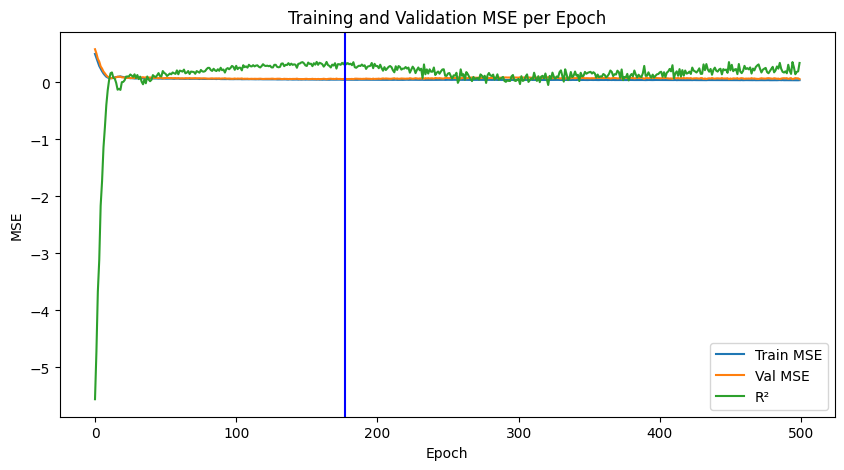

Predicted scores for unknown nodes: tensor([[0.7708],
        [0.8269],
        [0.8001],
        ...,
        [0.2461],
        [1.0930],
        [0.5502]])
Minimum Validation MSE: 0.05680812895298004 at epoch 177
 Training MSE: 0.047460753470659256
Best R² score: 0.3604181715585755 at epoch 177


In [19]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Set the seed
set_seed(42)
class GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=1):
        super(GAT, self).__init__()
        self.conv1 = gnn.GATConv(input_dim, hidden_dim, heads=heads)
        self.conv2 = gnn.GATConv(hidden_dim * heads, output_dim, heads=1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

    def predict(self, x, edge_index):
        with torch.no_grad():
            predicted_scores = self.forward(x, edge_index)
        return predicted_scores

# Assuming your data is in the `data` object
input_dim = node_features.shape[1]  # Number of input features
hidden_dim = 128  # Adjust as needed
output_dim = 1  # Predicting a single score

model_GAT = GAT(input_dim, hidden_dim, output_dim, heads=8)

# Optimizer and loss function
optimizer = torch.optim.Adam(model_GAT.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Split data into training and validation sets
valid_labels = data.y != -1
train_indices, val_indices = train_test_split(torch.where(valid_labels)[0], test_size=0.2, random_state=42)

train_losses = []
val_losses = []
r2_scores = []

# Training loop
for epoch in range(500):
    model_GAT.train()
    optimizer.zero_grad()
    out = model_GAT(data.x, data.edge_index)
    out = out.view(-1)
    # Select outputs and targets for training
    train_outputs = out[train_indices]
    train_targets = data.y[train_indices]
    # Calculate training loss
    train_loss = criterion(train_outputs, train_targets)
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())
    # Evaluation on validation set
    model_GAT.eval()
    with torch.no_grad():
        val_outputs = out[val_indices]
        val_targets = data.y[val_indices]
        val_loss = criterion(val_outputs, val_targets)
        val_losses.append(val_loss.item())
        r2 = r2_score(val_targets.cpu().numpy(), val_outputs.cpu().numpy())
        r2_scores.append(r2)

    print(f"Epoch {epoch}: Train MSE: {train_loss.item()}, Val MSE: {val_loss.item()} and R2 is {r2}")

# Plot training and validation MSE
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train MSE')
plt.plot(val_losses, label='Val MSE')
plt.plot(r2_scores, label='R²')
plt.axvline(x = r2_scores.index(max(r2_scores)), color = 'b',linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Validation MSE per Epoch')
plt.legend()
plt.show()

# Predict for nodes with unknown labels
model_GAT.eval()
with torch.no_grad():
    predicted_scores = model_GAT(data.x, data.edge_index)
    unknown_labels = data.y == -1
    predicted_unknown_scores = predicted_scores[unknown_labels]
    print("Predicted scores for unknown nodes:", predicted_unknown_scores)

print(f'Minimum Validation MSE: {min(val_losses)} at epoch {val_losses.index(min(val_losses))}')
print(f' Training MSE: {train_losses[val_losses.index(min(val_losses))]}')
print(f'Best R² score: {max(r2_scores)} at epoch {r2_scores.index(max(r2_scores))}')


## Backup where the GraphSage is good but only runs if it is run after GCN code below it


Epoch 0: Train MSE: 0.7780662178993225, Val MSE: 1.007732629776001 and R2 is -10.345691254520636
Epoch 1: Train MSE: 0.6475753784179688, Val MSE: 0.797379732131958 and R2 is -7.97740510702141
Epoch 2: Train MSE: 0.6547052264213562, Val MSE: 0.7140893936157227 and R2 is -7.039669907562592
Epoch 3: Train MSE: 0.5044602155685425, Val MSE: 0.61689293384552 and R2 is -5.945371362260278
Epoch 4: Train MSE: 0.49252861738204956, Val MSE: 0.6377489566802979 and R2 is -6.180181705795358
Epoch 5: Train MSE: 0.4247629642486572, Val MSE: 0.5870705246925354 and R2 is -5.609611105181431
Epoch 6: Train MSE: 0.38005155324935913, Val MSE: 0.4525409936904907 and R2 is -4.094992818479101
Epoch 7: Train MSE: 0.3361327350139618, Val MSE: 0.4378312826156616 and R2 is -3.9293812998630404
Epoch 8: Train MSE: 0.30324840545654297, Val MSE: 0.41605710983276367 and R2 is -3.684234757872553
Epoch 9: Train MSE: 0.25989609956741333, Val MSE: 0.34939154982566833 and R2 is -2.9336709878078233
Epoch 10: Train MSE: 0.230

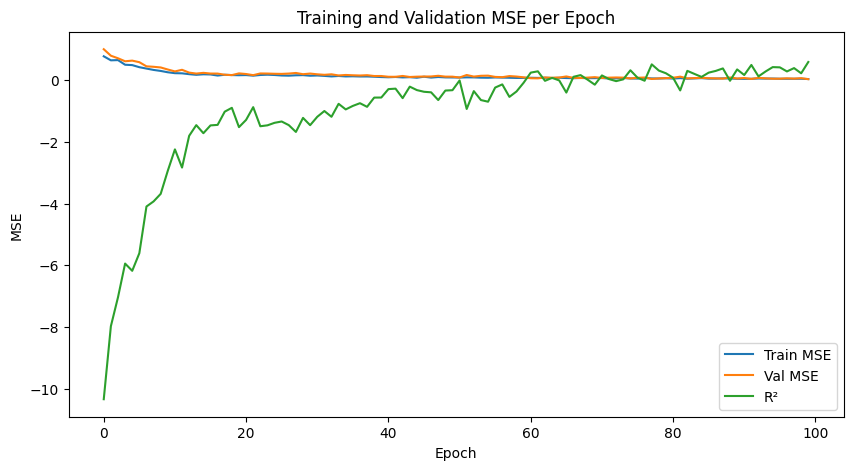

Predicted scores for unknown nodes: tensor([[0.1118],
        [0.0467],
        [0.0486],
        ...,
        [0.0610],
        [0.1991],
        [0.0947]])
Minimum Validation MSE: 0.03607496991753578 at epoch 99
Best R² score: 0.5938451478085317 at epoch 99


In [76]:
import torch
import torch.nn as nn
import torch_geometric.nn as gnn
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

class GraphSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGE, self).__init__()
        self.conv1 = gnn.SAGEConv(input_dim, hidden_dim)
        self.conv2 = gnn.SAGEConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

    def predict(self, x, edge_index):
        with torch.no_grad():
            predicted_scores = self.forward(x, edge_index)
        return predicted_scores

# Assuming your data is in the `data` object
input_dim = node_features.shape[1]  # Number of input features
hidden_dim = 128  # Adjust as needed
output_dim = 1  # Predicting a single score

model = GraphSAGE(input_dim, hidden_dim, output_dim)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Split data into training and validation sets
valid_labels = data.y != -1
train_indices, val_indices = train_test_split(torch.where(valid_labels)[0], test_size=0.2, random_state=42)

train_losses = []
val_losses = []
r2_scores = []

# Training loop
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    out = out.view(-1)
    # Select outputs and targets for training
    train_outputs = out[train_indices]
    train_targets = data.y[train_indices]
    # Calculate training loss
    train_loss = criterion(train_outputs, train_targets)
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())
    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        val_outputs = out[val_indices]
        val_targets = data.y[val_indices]
        val_loss = criterion(val_outputs, val_targets)
        val_losses.append(val_loss.item())
        r2 = r2_score(val_targets.cpu().numpy(), val_outputs.cpu().numpy())
        r2_scores.append(r2)

    print(f"Epoch {epoch}: Train MSE: {train_loss.item()}, Val MSE: {val_loss.item()} and R2 is {r2}")

# Plot training and validation MSE
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train MSE')
plt.plot(val_losses, label='Val MSE')
plt.plot(r2_scores, label='R²')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Validation MSE per Epoch')
plt.legend()
plt.show()

# Predict for nodes with unknown labels
model.eval()
with torch.no_grad():
    predicted_scores = model(data.x, data.edge_index)
    unknown_labels = data.y == -1
    predicted_unknown_scores = predicted_scores[unknown_labels]
    print("Predicted scores for unknown nodes:", predicted_unknown_scores)

print(f'Minimum Validation MSE: {min(val_losses)} at epoch {val_losses.index(min(val_losses))}')
print(f'Best R² score: {max(r2_scores)} at epoch {r2_scores.index(max(r2_scores))}')
